<h1 style="font-size:2.5rem;color:purple;">Artificial Intelligence II</h1>
<h1 style="font-size:1.5rem;color:purple;">Deep Learning for Natural Language Processing (NLP)</h1>

In this assignment, we develop a sentiment classifier using **Deep Neural Networks** and **Word2Vec word embeddings** in Python on a given Twitter dataset (the same dataset used in Logistic Regression project).  
The dataset consists of three files: *train_dataset.csv, val_dataset.csv, test_dataset.csv*.  
Train and Val consists of three columns: **ID, Text, Label**, and Test consists of two columns: **ID, Text**.

In [44]:
# Import libraries

import pandas as pd

import warnings

import re

import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from collections import Counter

import numpy as np

from gensim.models import Word2Vec

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve

In [3]:
# Ingore warnings
warnings.filterwarnings("ignore")

In [4]:
np.random.seed(42)

First we load the given data (*train.csv* to use for training, *val.csv* to use for validation of training and *test.csv* to use for predictions)

In [5]:
# Read train dataset (to use for training)
df_train = pd.read_csv('../datasets/train_dataset.csv')

# Read val dataset (to use for validation of training)
df_val = pd.read_csv('../datasets/val_dataset.csv')

# Read test dataset (to use for predictions)
df_test = pd.read_csv('../datasets/test_dataset.csv')

Let's take a look at the train dataset (the other two datasets have a similar structure to this one)

In [6]:
df_train

,ID,Text,Label
0,189385,@whoisralphie dude I'm so bummed ur leaving!,0
1,58036,"oh my god, a severed foot was foun in a wheely...",0
2,190139,I end up &quot;dog dialing&quot; sumtimes. Wha...,1
3,99313,@_rachelx meeeee toooooo!,0
4,157825,"I was hoping I could stay home and work today,...",0
...,...,...,...
148383,99894,just love the jonas brothers its tooo bad i w...,0
148384,61015,another day gone by....time is moving so fast...,0
148385,36598,"fuck college, i'm just gonna marry rich. : fuc...",1
148386,83799,ZOMGZ NEW SONG FTW. remember that night. &lt;3,1


<h1 style="font-size:1.5rem;color:purple;">Data Preprocessing</h1>
<h1 style="font-size:1.2rem;color:purple;">In this section we clean the datasets.</h1>

First we remove unwanted symbols/characters (e.g. URLs, @mentions, numbers/characters, hashtags).

In [7]:
# Function to clean text

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove mentions/usernames
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags but keep the words
    text = re.sub(r'#(\w+)', r'\1', text)
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Zά-ώΑ-Ω\s]', '', text)
    # Normalize spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

Clean text column in every dataframe

In [8]:
# Clean only Text column
df_train['Text'] = df_train['Text'].apply(clean_text)
df_val['Text'] = df_val['Text'].apply(clean_text)
df_test['Text'] = df_test['Text'].apply(clean_text)

Convert all text to lowercase

In [9]:
def text_lower(text):
    # Convert to lowercase
    text = text.lower()

    return text

In [10]:
df_train['Text'] = df_train['Text'].apply(text_lower)
df_val['Text'] = df_val['Text'].apply(text_lower)
df_test['Text'] = df_test['Text'].apply(text_lower)

Now take a look at the same dataset as above, but cleaned (the other two datasets are cleaned as well)

In [11]:
df_train

,ID,Text,Label
0,189385,dude im so bummed ur leaving,0
1,58036,oh my god a severed foot was foun in a wheely ...,0
2,190139,i end up quotdog dialingquot sumtimes whats do...,1
3,99313,meeeee toooooo,0
4,157825,i was hoping i could stay home and work today ...,0
...,...,...,...
148383,99894,just love the jonas brothers its tooo bad i wi...,0
148384,61015,another day gone bytime is moving so fast,0
148385,36598,fuck college im just gonna marry rich fuck col...,1
148386,83799,zomgz new song ftw remember that night lt,1


Drop rows with NaN values

In [12]:
# Drop NaN values
df_train = df_train.replace(r'^\s*$', pd.NA, regex=True).dropna()
df_val = df_val.replace(r'^\s*$', pd.NA, regex=True).dropna()

Reduce repeated characters in 2 (e.g. meeeeee toooooo -> mee too)

Function to reduce repeated characters

In [13]:
# Function to reduce repeated characters to 2
def reduce_repeated_characters(text):
   
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)  # Reduce characters repeated (3 or more times) to 2
    return text

Reduce repeated characters in Text columns

In [14]:
df_train['Text'] = df_train['Text'].apply(reduce_repeated_characters)
df_val['Text'] = df_val['Text'].apply(reduce_repeated_characters)
df_test['Text'] = df_test['Text'].apply(reduce_repeated_characters)

In [15]:
df_train

,ID,Text,Label
0,189385,dude im so bummed ur leaving,0
1,58036,oh my god a severed foot was foun in a wheely ...,0
2,190139,i end up quotdog dialingquot sumtimes whats do...,1
3,99313,mee too,0
4,157825,i was hoping i could stay home and work today ...,0
...,...,...,...
148383,99894,just love the jonas brothers its too bad i wil...,0
148384,61015,another day gone bytime is moving so fast,0
148385,36598,fuck college im just gonna marry rich fuck col...,1
148386,83799,zomgz new song ftw remember that night lt,1


Replace some frequent slang words with their original form

Create a dictionary with slang and original words

In [16]:
# Create a dictionary with slang word and their original form
abbreviations = {
    "im": "i am",
    "ur": "you are",
    "u": "you",
    "bummed": "sad",
    "mee": "me",
    "soo": "so",
    "ily": "i love you",
    "ok": "okay",
    "oke": "okay",
    "noo": "no",
    "luv": "love",
    "fb": "facebook",
    "cuz": "because",
    "ikr": "i know",
    "kno": "know",
    "knoo": "know",
    "sos": "help",
    "omg": "oh my god",
    "smh": "somehow",
    "bday": "birthday",
    "wtf": "what the fuck"
}

Function to replace slang words

In [17]:
# Function to replace slang
def replace_slang(text):
   
    for abbrev, full_form in abbreviations.items():
        text = re.sub(rf'\b{abbrev}\b', full_form, text, flags=re.IGNORECASE)
    
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

Replaced slang from all Text columns

In [18]:
df_train['Text'] = df_train['Text'].apply(replace_slang)
df_val['Text'] = df_val['Text'].apply(replace_slang)
df_test['Text'] = df_test['Text'].apply(replace_slang)

In [19]:
df_train

,ID,Text,Label
0,189385,dude i am so sad you are leaving,0
1,58036,oh my god a severed foot was foun in a wheely ...,0
2,190139,i end up quotdog dialingquot sumtimes whats do...,1
3,99313,me too,0
4,157825,i was hoping i could stay home and work today ...,0
...,...,...,...
148383,99894,just love the jonas brothers its too bad i wil...,0
148384,61015,another day gone bytime is moving so fast,0
148385,36598,fuck college i am just gonna marry rich fuck c...,1
148386,83799,zomgz new song ftw remember that night lt,1


Remove stopwords from text

In [20]:
# Download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/christina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Function to remove stopwords

In [21]:
def remove_stopwords(text, language='english'):

    stop_words = set(stopwords.words(language))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    return ' '.join(filtered_words)

In [22]:
df_train['Text'] = df_train['Text'].apply(remove_stopwords)
df_val['Text'] = df_val['Text'].apply(remove_stopwords)
df_test['Text'] = df_test['Text'].apply(remove_stopwords)

Below is the Train dataframe after data preprocessing

In [23]:
df_train

,ID,Text,Label
0,189385,dude sad leaving,0
1,58036,oh god severed foot foun wheely bin cobham fou...,0
2,190139,end quotdog dialingquot sumtimes whats dog dia...,1
3,99313,,0
4,157825,hoping could stay home work today looks like m...,0
...,...,...,...
148383,99894,love jonas brothers bad wil never get see tears,0
148384,61015,another day gone bytime moving fast,0
148385,36598,fuck college gonna marry rich fuck college gon...,1
148386,83799,zomgz new song ftw remember night lt,1


Remove words "got" and "oh" since they're frequent and meaningless words for both labels

In [24]:
# Function to remove words "got" and "oh" from text
def remove_got(text):
    
    cleaned_text = re.sub(r'\b(got|oh)\b', '', text, flags=re.IGNORECASE)
    return re.sub(r'\s+', ' ', cleaned_text).strip()

In [25]:
df_train['Text'] = df_train['Text'].apply(remove_got)
df_val['Text'] = df_val['Text'].apply(remove_got)
df_test['Text'] = df_test['Text'].apply(remove_got)

Drop NaN values after data cleaning

In [26]:
# Drop NaN values
df_train = df_train.replace(r'^\s*$', pd.NA, regex=True).dropna()
df_val = df_val.replace(r'^\s*$', pd.NA, regex=True).dropna()

<h1 style="font-size:1.5rem;color:purple;">Analysis</h1>
<h1 style="font-size:1.2rem;color:purple;">In this section we will try to visualize the data and their statistics.</h1>

Create some wordclouds to make it clear and visible which words are used more often

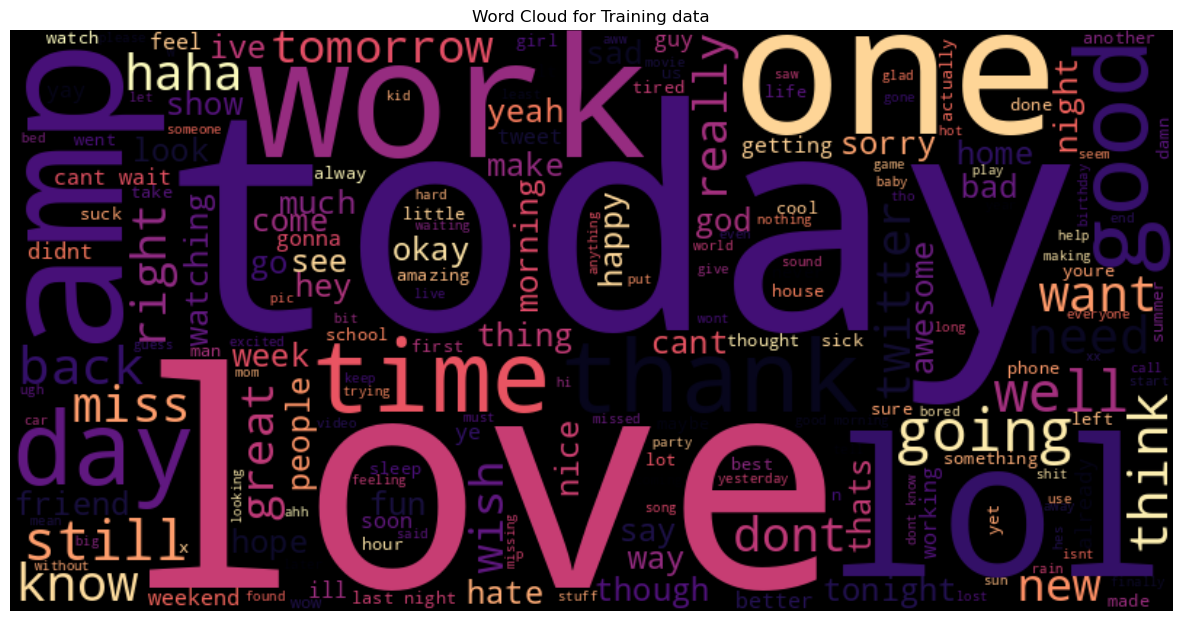

In [27]:
# Wordcloud for TRAINING DATA

# Combine all text entries into one string
text = " ".join(df_train['Text'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='magma').generate(text)

# Show the word cloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Training data")
plt.axis("off")
plt.show()

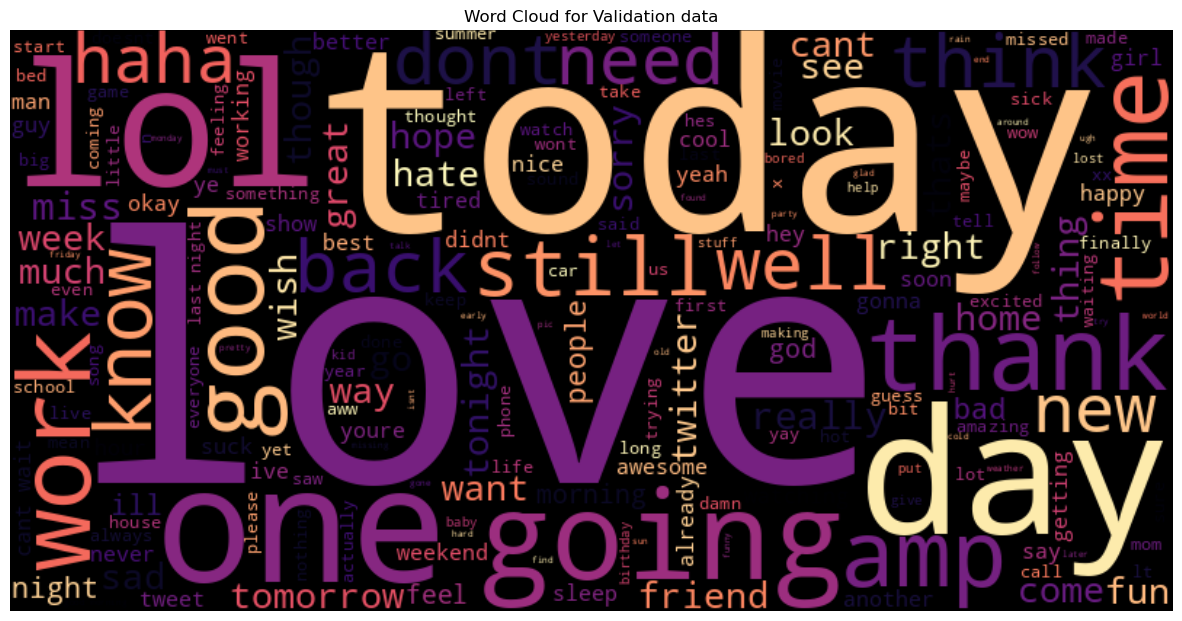

In [28]:
# Wordcloud for VALIDATION DATA

# Combine all text entries into one string
text = " ".join(df_val['Text'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='magma').generate(text)

# Show the word cloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Validation data")
plt.axis("off")
plt.show()

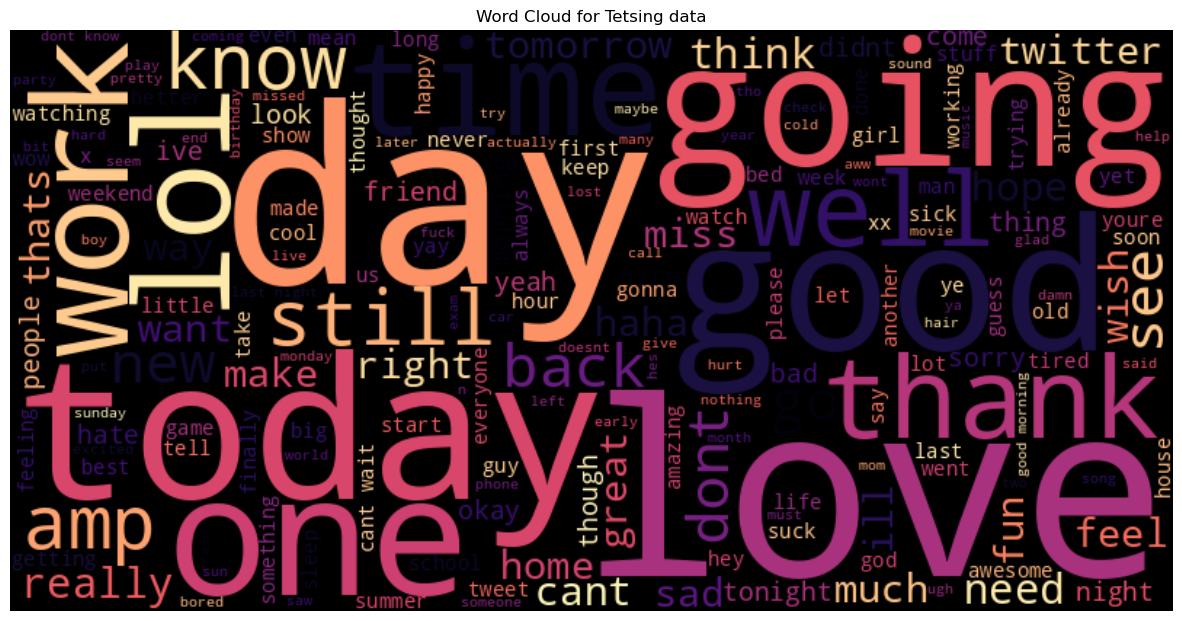

In [29]:
# Wordcloud for TESTING DATA

# Combine all text entries into one string
text = " ".join(df_test['Text'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='magma').generate(text)

# Show the word cloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Tetsing data")
plt.axis("off")
plt.show()

Find and print the number of labels (1 for positive, 0 for negative) in every dataframe  
(Test dataframe doesn't have "Label" column)

In [30]:
# Count labels
label_counts = df_train["Label"].value_counts()

print("Labels in Train data:")
label_counts

Labels in Train data:


Label
0    73791
1    73779
Name: count, dtype: int64

In [31]:
# Count labels
label_counts = df_val["Label"].value_counts()

print("Labels in Validation data:")
label_counts

Labels in Validation data:


Label
0    21105
1    21091
Name: count, dtype: int64

The labels seem to be balanced, since we have about equal numbers of positives and negatives in both dataframes.

Make some plots showing the top 10 most frequent words per label (for train set)

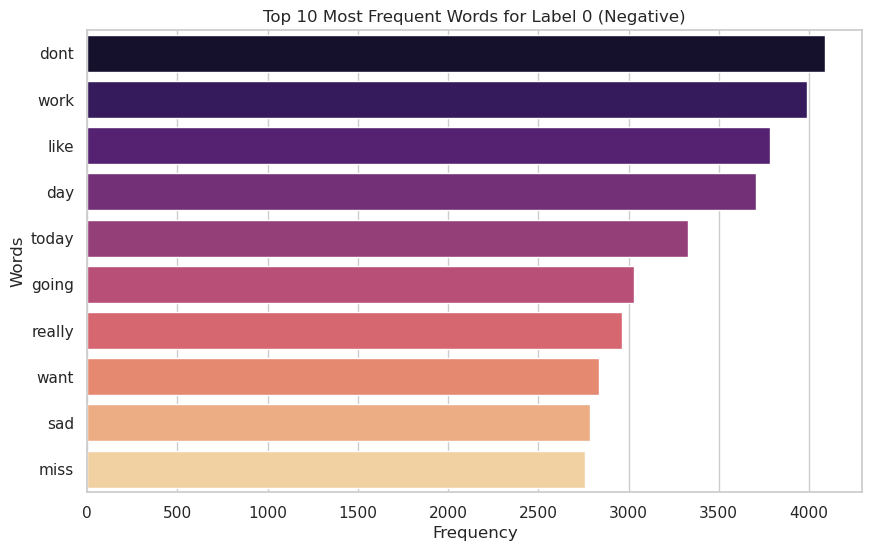

In [32]:
# Set CountVectorizer to count frequent words
vectorizer = CountVectorizer(stop_words='english')

sns.set(style='whitegrid')

label = 0
   
text_label = df_train[df_train['Label'] == label]['Text']
    
# Train CountVectorizer for this Label
X = vectorizer.fit_transform(text_label)
    
# Count frequent words
word_counts = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()
    
# Create a Counter to find top 10 frequent words
word_freq = Counter(dict(zip(words, word_counts)))
most_common_words = word_freq.most_common(10)

# Create plot for label
plt.figure(figsize=(10, 6))
plt.title(f'Top 10 Most Frequent Words for Label {label} (Negative)')
    
words, counts = zip(*most_common_words)
    
# Create bar plot
sns.barplot(x=counts, y=words, palette='magma')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

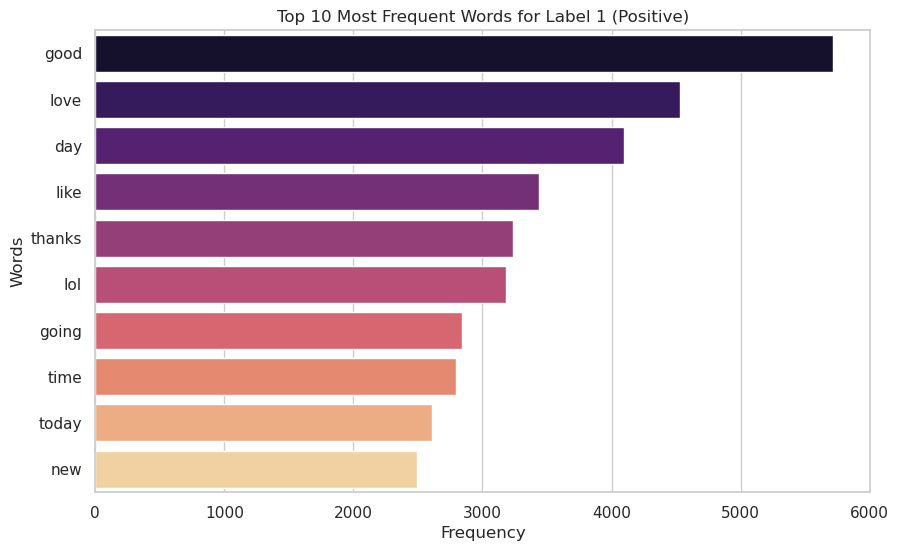

In [33]:
# Set CountVectorizer to count frequent words
vectorizer = CountVectorizer(stop_words='english')

sns.set(style='whitegrid')

label = 1
   
text_label = df_train[df_train['Label'] == label]['Text']
    
# Train CountVectorizer for this Label
X = vectorizer.fit_transform(text_label)
    
# Count frequent words
word_counts = X.sum(axis=0).A1
words = vectorizer.get_feature_names_out()
    
# Create a Counter to find top 10 frequent words
word_freq = Counter(dict(zip(words, word_counts)))
most_common_words = word_freq.most_common(10)

# Create plot for label
plt.figure(figsize=(10, 6))
plt.title(f'Top 10 Most Frequent Words for Label {label} (Positive)')
    
words, counts = zip(*most_common_words)
    
# Create bar plot
sns.barplot(x=counts, y=words, palette='magma')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

<h1 style="font-size:1.5rem;color:purple;">Vectorization</h1>
<h1 style="font-size:1.2rem;color:purple;">In this section we will convert text/data into numerical form so that it can be used by machine learning models.</h1>

We will train two versions of the **Word2Vec** model: the **CBOW** (Continuous Bag of Words) model and the **Skip-Gram** model. These models will then be used in DNN training to determine which one achieves the best accuracy.

Tokenization of train data

In [40]:
# Tokenization of train text
train_sentences = [text.split() for text in df_train['Text']]

**CBOW** Model

Train and save the model

In [ ]:
# Train Word2Vec (CBOW)
w2v_CBOW = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=2, sg=0)
w2v_CBOW.save("w2v_CBOW.model")

**Skip-Gram** Model

Train and save the model

In [46]:
# Train Word2Vec (Skip-Gram)
w2v_SkipGram = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=2, sg=1)
w2v_SkipGram.save("w2v_SkipGram.model")

Convert **Train**, **Val** and **Test** data in word embeddings using the trained Word2Vec models

In [47]:
# Function for vectorization
def text_to_vector(text, model):

    words = text.split()  # Tokenize text
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)  # Mean of vectors
    else:
        return np.zeros(model.vector_size)  # If no word found, return vector with zeros


Load trained models

In [48]:
w2v_CBOW = Word2Vec.load("w2v_CBOW.model")              # Load CBOW
w2v_SkipGram = Word2Vec.load("w2v_SkipGram.model")      # Load Skip-Gram

Convert train into vectors using two different Word2Vec models

In [69]:
# Convert train to vectors using CBOW model
train_vec_CBOW = np.array([text_to_vector(text, w2v_CBOW) for text in df_train['Text']])

In [70]:
train_vec_CBOW

array([[ 0.05315568,  0.86455417,  0.35837412, ...,  0.06986833,
         0.01317881, -0.42480886],
       [-0.19372468,  0.59266949, -0.20414972, ..., -0.34987667,
         0.38732433, -0.12642272],
       [-0.06372996,  0.25812808,  0.10127451, ..., -0.06151041,
         0.18210568,  0.0829305 ],
       ...,
       [-0.02365663,  0.23475119, -0.18424077, ..., -0.33872861,
         0.37003306,  0.07780664],
       [ 0.01007098,  0.92603564,  0.69833142, ..., -0.38811648,
        -0.48709264, -0.1093353 ],
       [-0.09306634,  0.11158682,  0.2083974 , ..., -0.45054987,
         0.20163533,  0.14409272]])

In [71]:
# Convert train to vectors using Skip-Gram
train_vec_SkipGram = np.array([text_to_vector(text, w2v_SkipGram) for text in df_train['Text']])

In [72]:
train_vec_SkipGram

array([[ 0.05797203,  0.29115859, -0.0071342 , ..., -0.05153003,
         0.1974047 , -0.16282576],
       [-0.13446587,  0.10976709, -0.1052452 , ..., -0.19533405,
         0.32819292, -0.14082275],
       [-0.0495926 ,  0.12517087,  0.10417091, ..., -0.09025235,
         0.11035325, -0.00867019],
       ...,
       [ 0.02770888,  0.09357722, -0.1581327 , ..., -0.22445431,
         0.16104858,  0.0253526 ],
       [-0.02062099,  0.35485169,  0.15025745, ..., -0.13800304,
        -0.11683774, -0.13887398],
       [-0.11406822,  0.04834944,  0.1369722 , ..., -0.23227623,
         0.11894036,  0.09756817]])

Convert val into vectors using two different Word2Vec models

In [49]:
# Convert val to vectors using CBOW model
val_vec_CBOW = np.array([text_to_vector(text, w2v_CBOW) for text in df_val['Text']])

In [52]:
val_vec_CBOW

array([[-0.23905726,  0.86663204,  0.0482804 , ...,  0.02900907,
         0.45518535,  0.02831444],
       [ 0.14390823,  0.50444525,  0.21544442, ..., -0.1791124 ,
         0.26799285, -0.27218166],
       [ 0.05877184,  0.27788422,  0.07859107, ..., -0.23764512,
         0.39738891, -0.01430488],
       ...,
       [ 0.12893781,  0.8720631 ,  0.16260339, ..., -0.19519997,
        -0.02419019,  0.13275532],
       [ 0.13990997,  0.6002329 ,  0.04792019, ...,  0.05898347,
         0.29483113, -0.24649204],
       [-0.20524569,  0.39656541,  0.22912279, ...,  0.07720768,
         0.20795317, -0.05925352]])

In [50]:
# Convert val to vectors using Skip-Gram
val_vec_SkipGram = np.array([text_to_vector(text, w2v_SkipGram) for text in df_val['Text']])

In [53]:
val_vec_SkipGram

array([[-0.15401696,  0.07442661,  0.11748593, ..., -0.09569176,
         0.20913213,  0.02305397],
       [-0.064605  ,  0.17841431,  0.17175607, ..., -0.23099139,
         0.12310877, -0.16387081],
       [-0.0365067 , -0.00978165,  0.06728367, ..., -0.20081393,
         0.23016833, -0.06068354],
       ...,
       [-0.05293532,  0.13701843,  0.07896765, ..., -0.16879143,
        -0.007582  , -0.04114103],
       [-0.09275225,  0.09221448,  0.11058474, ..., -0.12967589,
         0.14929426, -0.23313922],
       [-0.14856111,  0.16663538,  0.11989705, ..., -0.10501854,
        -0.00186654,  0.0111093 ]])

Now we will convert test data into vectors.  
*(This data will not be used for evaluation but only for making final predictions and generating the submission.csv file)* 

We will transform the test data using both Word2Vec models CBOW and Skip-Gram, just as we did before.  
*(For the final predictions, we will use the model that achieves the best accuracy on the validation set)*

In [58]:
# Convert test to vectors using CBOW model
test_vec_CBOW = np.array([text_to_vector(text, w2v_CBOW) for text in df_test['Text']])

In [59]:
test_vec_CBOW

array([[-6.02064766e-02,  5.60121715e-01,  3.69197071e-01, ...,
        -1.98012814e-01,  3.11726421e-01,  1.88315555e-01],
       [-9.97144431e-02,  6.90488338e-01,  1.90798100e-03, ...,
        -3.37292969e-01, -1.42629445e-02, -3.17371607e-01],
       [-2.17098407e-02,  4.55315918e-01, -9.30452496e-02, ...,
        -7.78406039e-02,  3.43537986e-01,  1.16044082e-01],
       ...,
       [ 5.04190564e-01,  4.24239397e-01,  8.95925015e-02, ...,
        -5.65961003e-04,  2.96783745e-01, -4.70192492e-01],
       [ 6.52934074e-01,  2.12470323e-01,  6.12808466e-02, ...,
        -2.71577179e-01,  4.19429958e-01, -1.23320758e-01],
       [-1.36973634e-01,  6.37392104e-01,  1.60513029e-01, ...,
        -3.51367563e-01,  1.85496524e-01, -2.65085667e-01]])

In [56]:
# Convert test to vectors using Skip-Gram
test_vec_SkipGram = np.array([text_to_vector(text, w2v_SkipGram) for text in df_test['Text']])

In [57]:
test_vec_SkipGram

array([[ 0.01338785,  0.17617604,  0.11980597, ..., -0.24607804,
         0.19686849,  0.04115413],
       [ 0.01221938,  0.27775043, -0.00251651, ..., -0.28131038,
         0.05429616, -0.15601613],
       [-0.1624535 ,  0.21799812,  0.0435714 , ..., -0.22548266,
         0.09987812,  0.03601064],
       ...,
       [-0.01943784,  0.00237042, -0.15564397, ...,  0.0127693 ,
         0.24812916, -0.26703954],
       [-0.0200861 ,  0.17853644,  0.21171856, ..., -0.10931277,
         0.20065238, -0.19611669],
       [-0.04552343,  0.21840809,  0.11962998, ..., -0.22938077,
        -0.01761946, -0.11359784]])

In [73]:
# Print shape of CBOW vetors (Must be (N_data, 100) , for vector_size=100)
print("Shape of CBOW vectors (vector_size=100):\n")
print("Train vector", train_vec_CBOW.shape) 
print("Validation vector", val_vec_CBOW.shape) 
print("Test vector", test_vec_CBOW.shape, "\n")

# Print shape of Skip-Gram vetors (Must be (N_data, 100) , for vector_size=100)
print("Shape of Skip-Gram vectors (vector_size=100):\n")
print("Train vector", train_vec_SkipGram.shape) 
print("Validation vector", val_vec_SkipGram.shape)
print("Test vector", test_vec_SkipGram.shape)

Shape of CBOW vectors (vector_size=100):

Train vector (147570, 100)
Validation vector (42196, 100)
Test vector (21199, 100) 

Shape of Skip-Gram vectors (vector_size=100):

Train vector (147570, 100)
Validation vector (42196, 100)
Test vector (21199, 100)
